In [1]:
import sys 
sys.path.append('../../src')

import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from spaceoracle.oracles import BaseTravLR
from spaceoracle.plotting.cartography import Cartography


/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
2025-08-12 12:36:56.241156: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/gcc-12.2.0/postgresql/15.2/lib:/ihome/crc/install/gcc-12.2.0/imagemagick/6.9.12/lib:/ihome/crc/install/gcc-12.2.0/geos/3.9.4/lib:/ihome/crc/install/gcc-12.2.0/zstd/zstd-1.5.5/lib:/ihome/crc/install/gcc-12.2.0/unixodbc/2.3.11/lib:/ihome/crc/install/sodium/1.0.18/lib:/ihome/crc/install/gcc-12.2.0/r/4.4.0/lib64/R/lib:/ihome/crc/install/gcc-12.2

In [2]:
import json

with open('colors.json', 'r') as f:
    color_dict = json.load(f)

In [3]:
adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_kidney_13.h5ad')
adata

AnnData object with n_obs × n_vars = 8509 × 3058
    obs: 'ct1', 'ct2', 'ct3', 'ct4', 'cond', 'medulla_cortex', 'domain', 'cell_type', 'cell_type_int'
    uns: 'cell_thresholds', 'cell_type_colors', 'neighbors', 'pca', 'received_ligands', 'received_ligands_tfl', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'

In [5]:
adata.obs.cell_type.value_counts()

cell_type
Myeloid                5266
Endothelial            1779
Epithelial              462
B                       442
T                       361
Mesenchymal_Stromal     128
NK                       71
Name: count, dtype: int64

In [11]:
tf = [
    "Spi1",   # PU.1
    "Nfkb1",  # NF-κB
    "Zeb2",
    "Foxd1",
    "Smad1",
    "Pitx2",
    "Hes1",
    "Hif1a",  # HIF1α
    "Myc",
    "Irf8",
    "Mafb",
    "Pax5",
    "Pax8",
    "Rora",
    "Ebf1"
]

receptors = [
    # "Cd44",
    "Pdgfrb",  # PDGFRβ
    "Egfr",
    "Cd74",
    # "Tnfrsf14",
    "Pecam1",  # CD31
    # "Ret",
    "Tfrc",
    "Il7r",
    "Cxcr4",
    'Tgfbr1',
    'Flt1',
    # 'Ccr5'
]

ligands = [
    "Hbegf",
    "Mif",     # Macrophage migration inhibitory factor
    "Cxcl10",
    "Tgfb2",
    "Tgfb3",
    "Vegfa",
    "Hgf",
    "Il1b",
    # "Cxcl12",
    # "Ccl2",
    # "Wnt4"
]

In [12]:
ligands = [x for x in ligands if x in adata.var_names]
receptors = [x for x in receptors if x in adata.var_names]
tf = [x for x in tf if x in adata.var_names]

len(ligands), len(receptors), len(tf)

(8, 9, 7)

In [18]:
priority_genes = set(ligands + receptors + tf)
priority_genes

{'Cd74',
 'Cxcl10',
 'Cxcr4',
 'Ebf1',
 'Egfr',
 'Flt1',
 'Hbegf',
 'Hes1',
 'Hgf',
 'Il1b',
 'Il7r',
 'Mafb',
 'Mif',
 'Pax5',
 'Pax8',
 'Pdgfrb',
 'Pecam1',
 'Rora',
 'Tfrc',
 'Tgfb2',
 'Tgfb3',
 'Tgfbr1',
 'Vegfa',
 'Zeb2'}

In [13]:
from spaceoracle.virtual_tissue import VirtualTissue

kidney = VirtualTissue(
    adata = adata,
    annot = 'cell_type',
    betadatas_path = '/ix/djishnu/shared/djishnu_kor11/lasso_runs/mouse_kidney_13',
    ko_path = '/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_kidney_13',
    color_dict=color_dict
)

In [14]:
[x for x in adata.var_names if x in tf]

['Pax8', 'Zeb2', 'Mafb', 'Pax5', 'Rora', 'Ebf1', 'Hes1']

In [15]:
sc.tl.rank_genes_groups(adata, groupby="cell_type", use_raw=False)
markers_df = pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).iloc[0:20, :]
markers_df.head(20)

,B,Endothelial,Epithelial,Mesenchymal_Stromal,Myeloid,NK,T
0,Ripor2,Emcn,Mpc2,Meis1,Cd74,Klrb1c,Skap1
1,Bank1,Egfl7,Oxct1,Gpc6,H2-Eb1,Ncr1,Bcl11b
2,Cd79b,Plpp1,Cox6c,Igfbp7,Tyrobp,Ripor2,Cd3g
3,Cd79a,Flt1,Ndufa4,Pard3b,C1qa,Klrk1,Ms4a4b
4,Aff3,Eng,Cisd1,Rora,Apobec1,Klre1,Lck
5,Bach2,Plvap,Cd63,Lama2,Cadm1,Klrd1,Cd3d
6,Cd37,Pbx1,Mpc1,Nr2f2,Tgfbr1,Ctsw,Cd3e
7,Ralgps2,Pecam1,Chpt1,Cacna1c,Pid1,Il2rb,Tnik
8,Pax5,Meis2,Phldb2,Cald1,Lcp1,Ms4a4b,Trbc2
9,Ikzf3,Exoc3l2,Ndufb9,Rbms3,Rbpj,Txk,Tmsb10


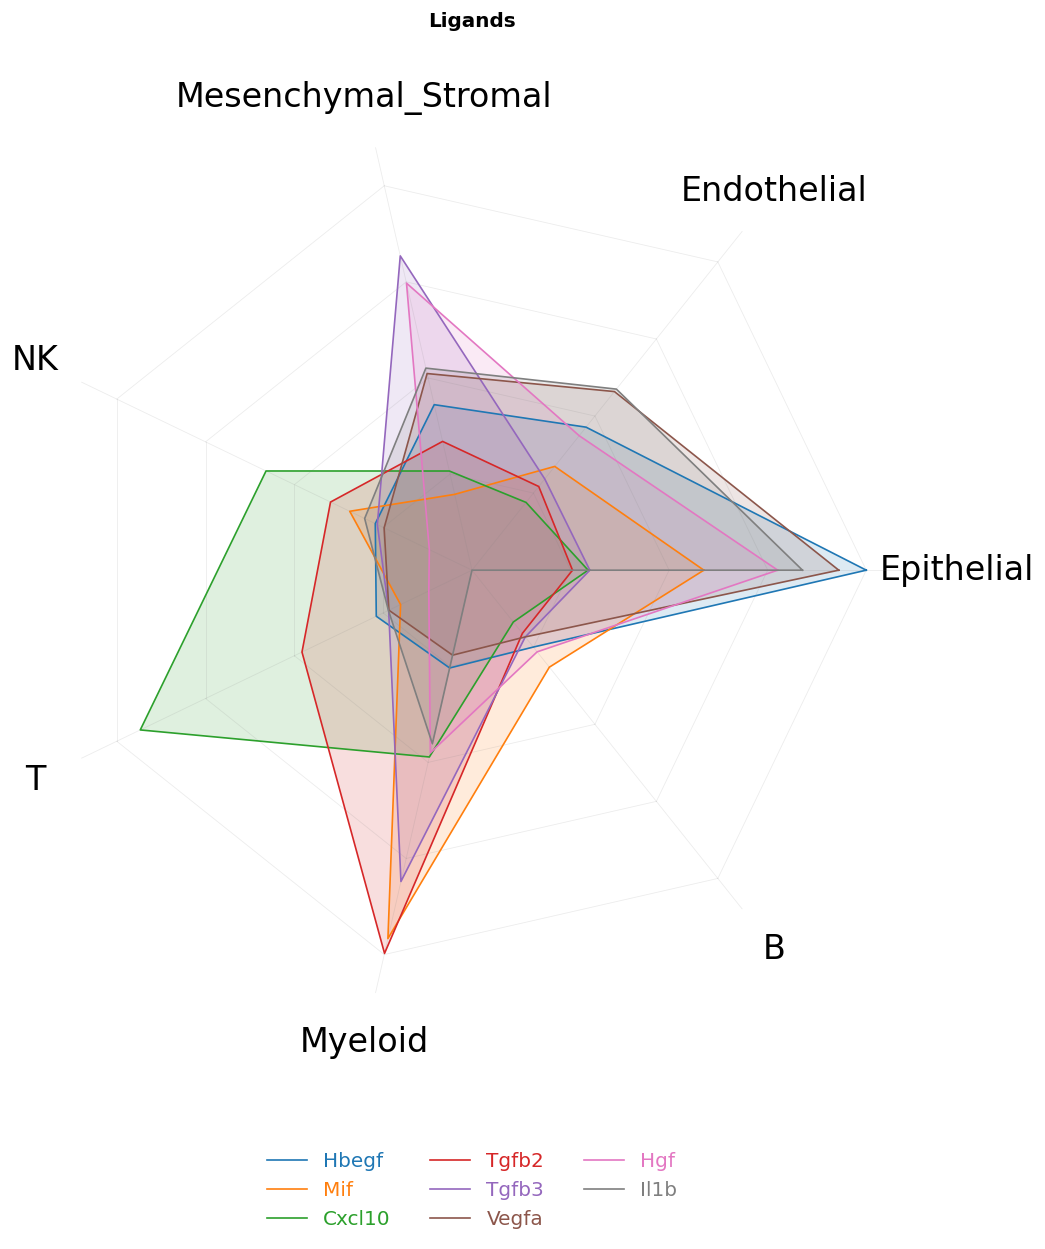

In [16]:
%matplotlib inline
kidney.plot_radar(genes=ligands, 
    cache_path='../../notebooks/mouse_kidney_survey/', 
    figsize=(20, 10),
    dpi=120,
)
plt.title('Ligands\n\n', fontweight='bold')
plt.savefig('./figures/spider_plot_ligands.svg', dpi=300, bbox_inches='tight', format='svg')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_kidney_13/Tfrc_4n_0x.parquet'

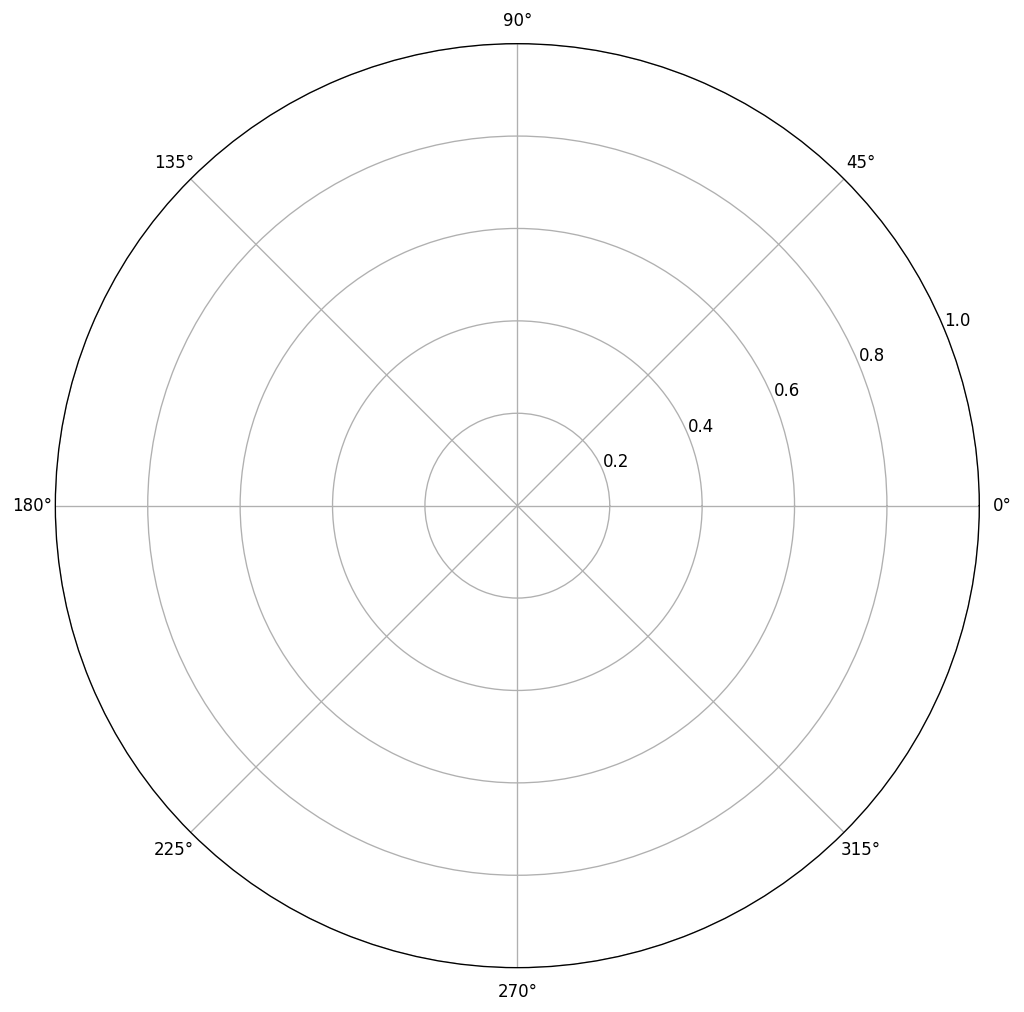

In [17]:
kidney.plot_radar(genes=receptors, 
    cache_path='../../notebooks/mouse_kidney_survey/', 
    figsize=(20, 10),
    dpi=120,
)
plt.title('Receptors\n\n', fontweight='bold')
plt.savefig('./figures/spider_plot_receptors.svg', dpi=300, bbox_inches='tight', format='svg')
plt.show()

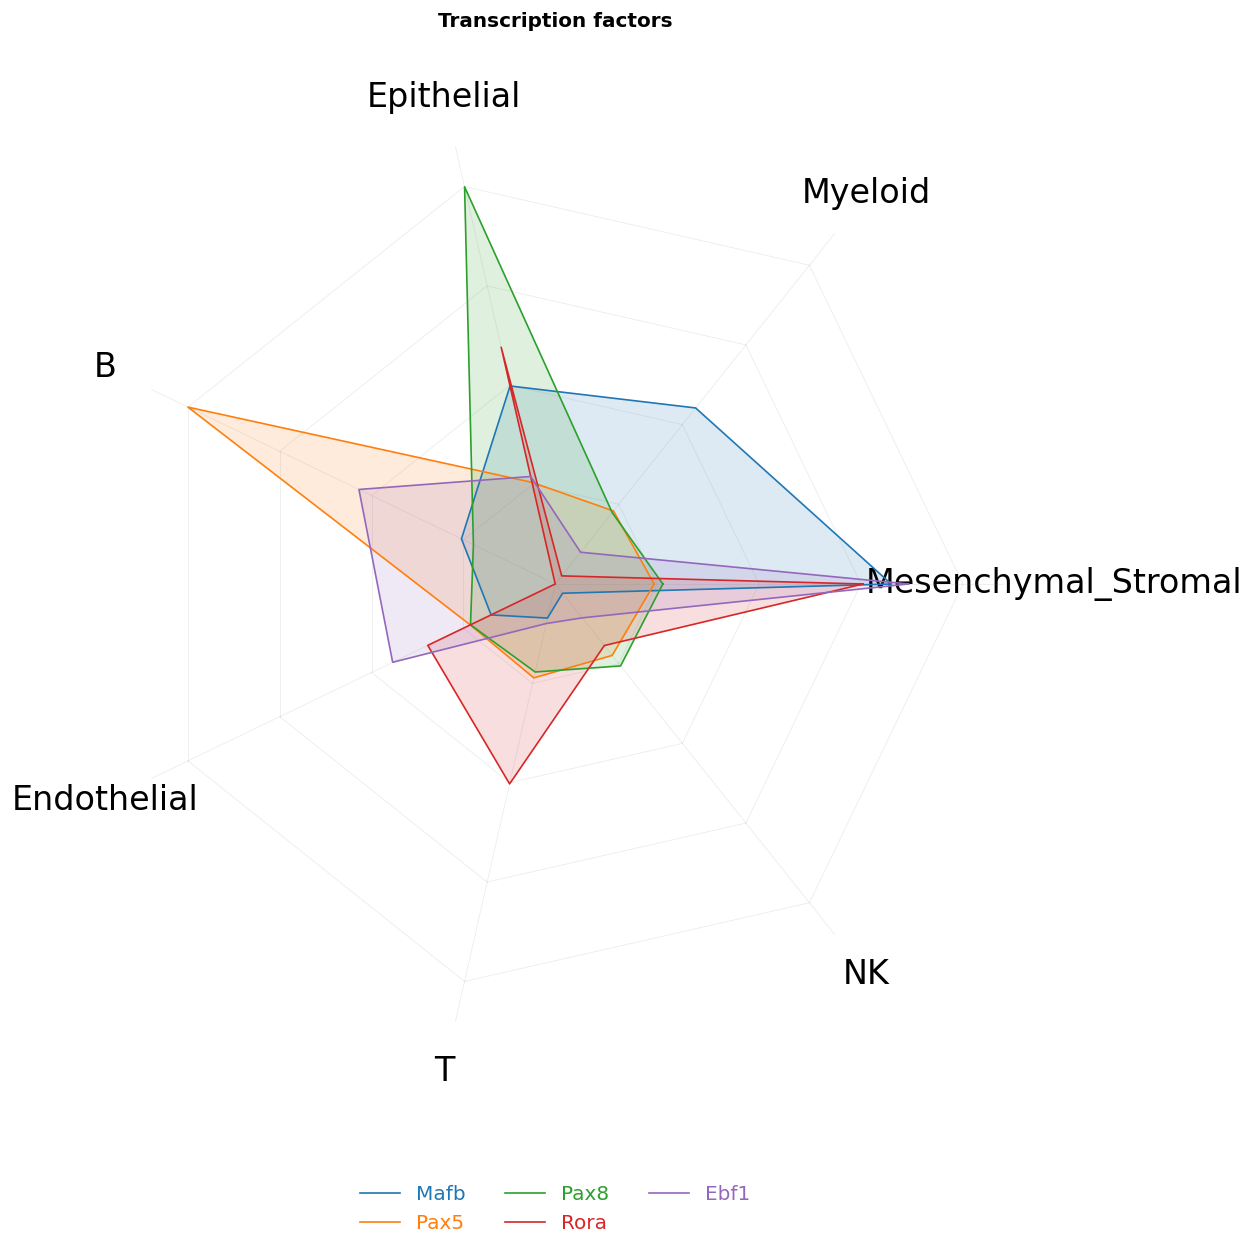

In [36]:

kidney.plot_radar(genes=tf, 
    cache_path='../../notebooks/mouse_kidney_survey/', 
    figsize=(20, 10),
    dpi=120,
)
plt.title('Transcription factors\n\n', fontweight='bold')
plt.savefig('./figures/spider_plot_tf.svg', dpi=300, bbox_inches='tight', format='svg')
plt.show()

In [ ]:
from spaceoracle.virtual_tissue import VirtualTissue

covet = VirtualTissue(
    adata = adata,
    annot = 'cell_type',
    betadatas_path = '/ix/djishnu/shared/djishnu_kor11/covet_runs/mouse_kidney_13',
    ko_path = '/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_kidney_13_COVET',
    color_dict=color_dict
)